In [ ]:
from IPython.display import FileLink

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(phyloseq)
library(ggplot2)
library(plyr); library(dplyr)

Find out what's changed in ggplot2 with
news(Version == "1.0.0", package = "ggplot2")

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [ ]:
%%R
physeq.bact = import_biom("../data/B/otu_table.wtax_wsd.biom")
physeq.bact.snorm = transform_sample_counts(physeq.bact, function(x) x / sum(x))
physeq.bact.snorm = subset_taxa(physeq.bact.snorm, Rank2 != "Cyanobacteria")
mdf.bact = tbl_df(psmelt(physeq.bact.snorm))

In [ ]:
%%R
physeq.euk = import_biom("../data/A/otu_table.wtax_wsd.biom")
physeq.euk.snorm = transform_sample_counts(physeq.euk, function(x) x / sum(x))
physeq.euk.snorm = subset_taxa(physeq.euk.snorm, Rank1 == "Eukaryota" | Rank2 == "Cyanobacteria")
mdf.euk = tbl_df(psmelt(physeq.euk.snorm))

In [ ]:
%%R
p.ranks.bact = mdf.bact %.% 
            filter(EnvironmentType == "planktonic") %.% 
            group_by(Sample) %.%
            mutate(rank = rank(-Abundance, ties.method = "first")) %.%
            select(OTU, CarbonToPhosphorous, Date, rank)
mdf.bact.wRanks = left_join(mdf.bact, p.ranks.bact, by = c("Date", "OTU", "CarbonToPhosphorous"))
mdf.bact.wRanks$LibraryType = '"Heterotrophs"'

In [ ]:
%%R
p.ranks.euk = mdf.euk %.% 
            filter(EnvironmentType == "planktonic") %.% 
            group_by(Sample) %.%
            mutate(rank = rank(-Abundance, ties.method = "first")) %.%
            select(OTU, CarbonToPhosphorous, Date, rank)
mdf.euk.wRanks = left_join(mdf.euk, p.ranks.euk, by = c("Date", "OTU", "CarbonToPhosphorous"))
mdf.euk.wRanks$LibraryType = "Photoautotrophs"

In [ ]:
%%R
mdf.both = rbind.fill(mdf.bact.wRanks, mdf.euk.wRanks)

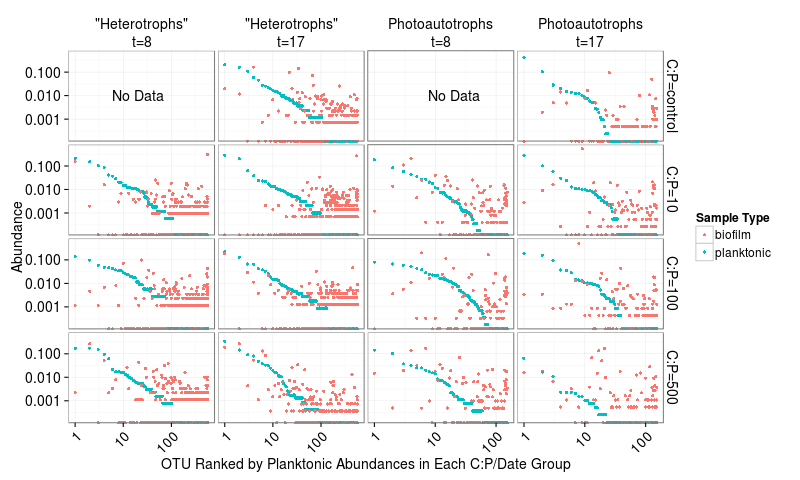

In [ ]:
%%R -w 800

mdf.both$Date.strip = factor(paste("t=",mdf.both$Date,sep=""), levels = c("t=8", "t=17"))
mdf.both$CarbonToPhosphorous.strip = factor(paste("C:P=",mdf.both$CarbonToPhosphorous,sep=""),
                                            levels = c("C:P=control", 
                                                       "C:P=10", 
                                                       "C:P=100", 
                                                       "C:P=500"))

p = ggplot(mdf.both, aes(x = rank, y = Abundance, color = EnvironmentType))

p = p + geom_point(size = 1.5)

p = p + facet_grid(CarbonToPhosphorous.strip ~ LibraryType + Date.strip, scales = "free_x")

p = p + scale_y_log10()

p = p + scale_x_log10()

p = p + labs(x = "OTU Ranked by Planktonic Abundances in Each C:P/Date Group")

d = data.frame(CarbonToPhosphorous.strip = "C:P=control",
               LibraryType = c("Photoautotrophs", '"Heterotrophs"'),
               Date.strip = "t=8",
               x = 20,
               y = 0.01,
               t = "No Data")

p = p + geom_text(data = d, aes(label = t, x = x, y = y), color = "black")

p = p + theme_bw()
p = p + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 14), 
              axis.text.y = element_text(size = 14), 
              axis.title.x = element_text(size = 14), 
              axis.title.y = element_text(size = 14), 
              strip.text.x = element_text(size = 14), 
              strip.text.y = element_text(size = 14),
              legend.text = element_text(size = 12), 
              legend.title = element_text(size = 12), 
              strip.background = element_blank())

p = p + labs(color = "Sample Type")

p

In [ ]:
%%R
ggsave("figs/rank_abund.pdf", p, h = 8, w = 11)

In [ ]:
FileLink("figs/rank_abund.pdf")

/home/chuck/working/carbon_subsidies_biofilm_plankton/BvP_manuscript_figures/figures_and_stats/figs/rank_abund.pdf